# <h1><center>BÀI THỰC HÀNH: HIỆU CHỈNH CAMERA SỬ DỤNG OPENCV (CAMERA CALIBRATION)</center></h1>

In [60]:
# Các thư viện cần thiết
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import math

## Hiển thị ảnh bàn cờ khi trước khi được căn chỉnh
### - Tổng số ảnh: 14
### - Kích thước bàn cờ: 12x8

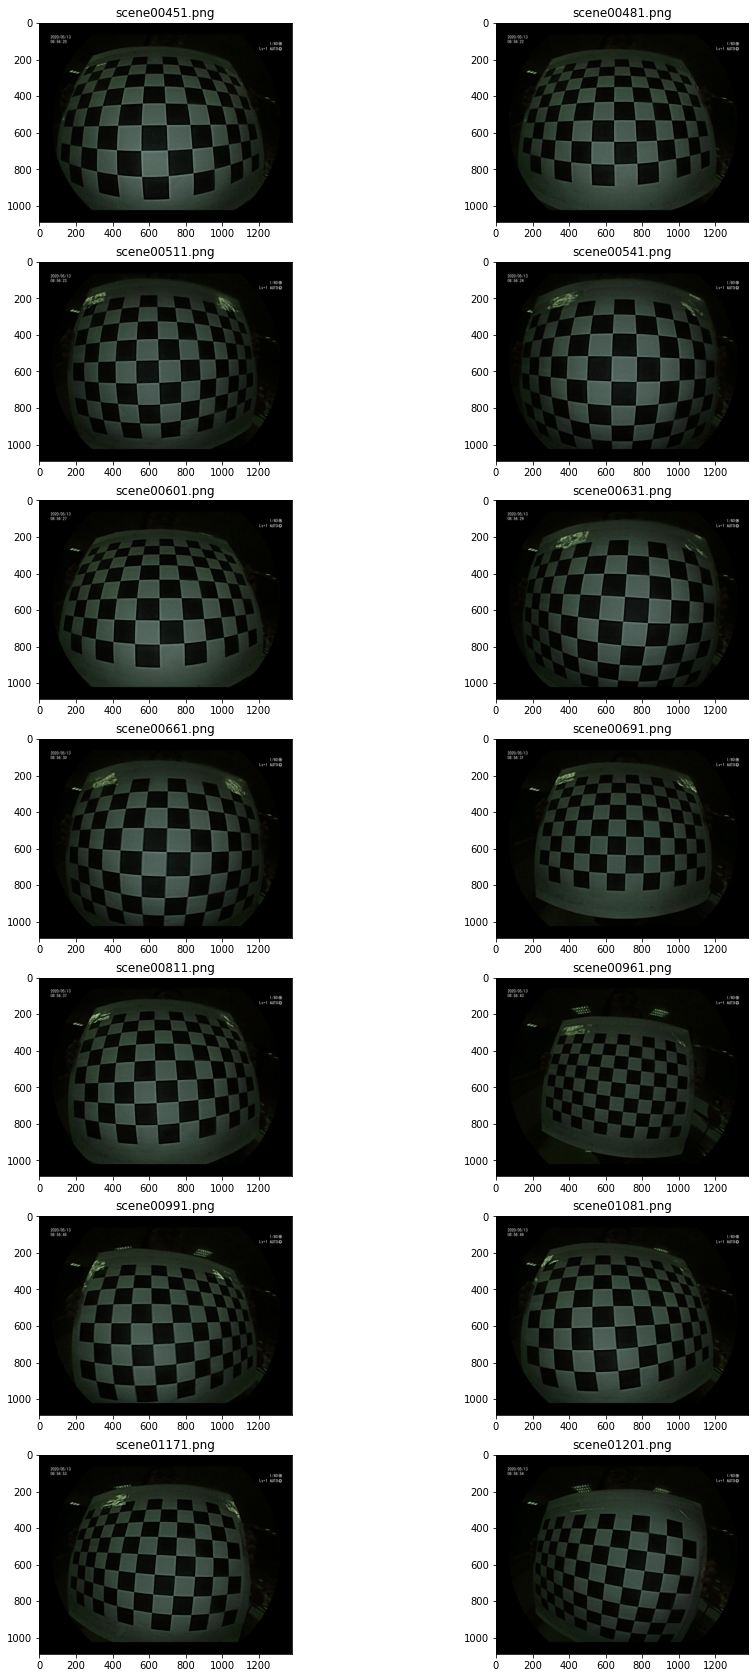

In [61]:
images=glob.glob('chessboard/*.png')
column=2
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))

In [62]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

In [63]:
# chessboard dimension (12 x 8) however we need objpoints and imgpoints to have same number of entries and of same size
# Kích thước của bàn cờ (12x8) tuy nhiên chúng ta cần objpoints và impoints có cùng chỉ mục và kích thước
cbrow = 11
cbcolumn = 7

In [64]:
# Chuẩn bị object points giống như: (0,0,0), (1,0,0), ...., (10,6,0)
objp = np.zeros((cbrow*cbcolumn, 3), np.float32)
objp[:, :2] = np.mgrid[0:cbrow, 0:cbcolumn].T.reshape(-1, 2)
objp, objp.shape

(array([[ 0.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 2.,  0.,  0.],
        [ 3.,  0.,  0.],
        [ 4.,  0.,  0.],
        [ 5.,  0.,  0.],
        [ 6.,  0.,  0.],
        [ 7.,  0.,  0.],
        [ 8.,  0.,  0.],
        [ 9.,  0.,  0.],
        [10.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 1.,  1.,  0.],
        [ 2.,  1.,  0.],
        [ 3.,  1.,  0.],
        [ 4.,  1.,  0.],
        [ 5.,  1.,  0.],
        [ 6.,  1.,  0.],
        [ 7.,  1.,  0.],
        [ 8.,  1.,  0.],
        [ 9.,  1.,  0.],
        [10.,  1.,  0.],
        [ 0.,  2.,  0.],
        [ 1.,  2.,  0.],
        [ 2.,  2.,  0.],
        [ 3.,  2.,  0.],
        [ 4.,  2.,  0.],
        [ 5.,  2.,  0.],
        [ 6.,  2.,  0.],
        [ 7.,  2.,  0.],
        [ 8.,  2.,  0.],
        [ 9.,  2.,  0.],
        [10.,  2.,  0.],
        [ 0.,  3.,  0.],
        [ 1.,  3.,  0.],
        [ 2.,  3.,  0.],
        [ 3.,  3.,  0.],
        [ 4.,  3.,  0.],
        [ 5.,  3.,  0.],
        [ 6.,  3.,  0.],


In [65]:
# Mảng đề lưu object points và image points từ toàn bộ các ảnh đảm bảo 2 mảng này có cùng kích thước
objpoints = []  # lưu trữ tọa độ 3d trong không gian thế giới thực (3d point in real world space)
imgpoints = []   # Lưu tọa độ 2D trên ảnh (2d point in image plane)

In [66]:
# Lấy toàn bộ ảnh trong folder
images = glob.glob("chessboard/*.png")
i = 0
for fname in images:
    i = i + 1
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Tìm góc của bàn cờ (find the chessboard corners)
    ret, corners = cv2.findChessboardCorners(gray, (11, 7), flags=cv2.CALIB_CB_FILTER_QUADS + cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK)
    # Nếu tìm thấy, thêm vào các điểm của đối tượng, điểm của ảnh (sau khi tinh chỉnh) (if found, add object points, image points (after refining them))
    if ret == True:
        corners2 = cv2.cornerSubPix(
            gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        objpoints.append(objp)
        # Vẽ và hiển thị các góc (Draw and display the corners)
        img = cv2.drawChessboardCorners(img, (cbrow, cbcolumn), corners2, ret)
        cv2.imshow('Image', img)
        cv2.waitKey(0)
    else:
        os.remove(fname)
cv2.destroyAllWindows()

In [67]:
##### Hiệu chỉnh (CALIBRATION) ######
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None, flags=cv2.CALIB_RATIONAL_MODEL)
dist = np.array(dist)

## UNDISTORTION đối với ảnh bàn cờ ban đầu

In [68]:
##### UNDISTORTION #####
img1 = cv2.imread("chessboard/scene00451.png")
h, w = img1.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(
    mtx, dist, (w, h), 1, (w, h))

resultImg = glob.glob("chessboard/*.png")
for rimg in resultImg:
    img = cv2.imread(rimg)
    
    # undistort
    mapx, mapy = cv2.initUndistortRectifyMap(
        mtx, dist, None, newcameramtx, (w, h), 5)
    dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # Ghi ản kết quả
    path = "chessboard/result/Calibresult_" + \
        os.path.basename(rimg)
    cv2.imwrite(path, dst)

# Lỗi phép chiếu (re-projection error)
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(
        objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print("total error", mean_error/len(objpoints))
cv2.waitKey(0)
cv2.destroyAllWindows()


total error 0.21195605444670207


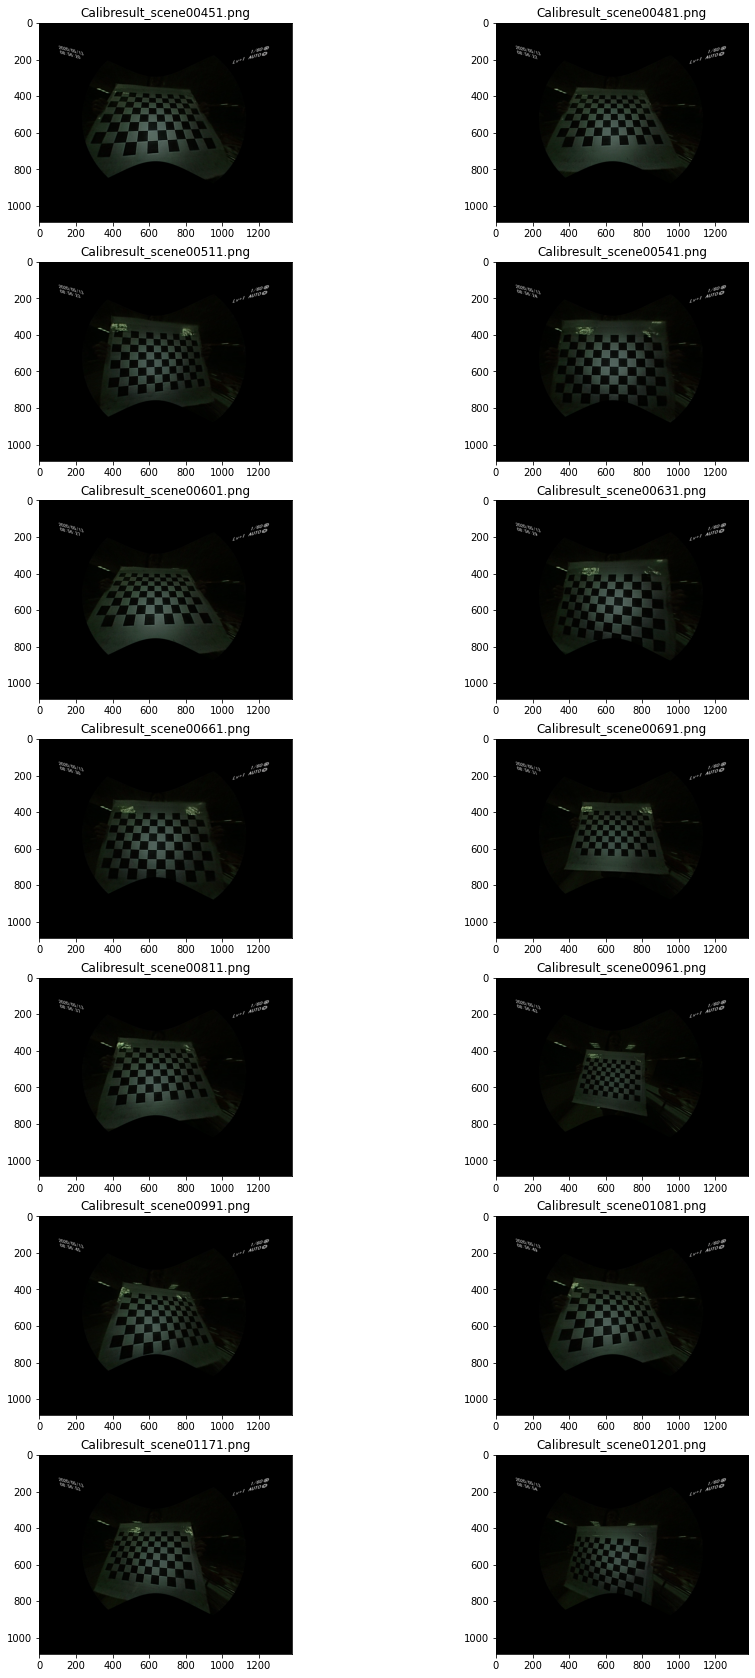

In [69]:
images=glob.glob('chessboard/result/*.png')
column=2
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))

## UNDISTORTION đối với ảnh bàn cờ ko phát hiện ra góc

In [70]:
##### UNDISTORTION #####
img1 = cv2.imread("chessboard_unknow/scene00421.png")
h, w = img1.shape[:2]
############Your code Here##################
newcameramtx, roi = None
##############################################
resultImg = glob.glob("chessboard_unknow/*.png")
for rimg in resultImg:
    img = cv2.imread(rimg)
    
    # #############Your code here#############
    # undistort
    mapx, mapy = None
    dst = None
    #################################################
    # Ghi ản kết quả
    path = "chessboard_unknow/result/Calibresult_" + \
        os.path.basename(rimg)
    cv2.imwrite(path, dst)

# Lỗi phép chiếu (re-projection error)
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(
        objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    ####################Your Code Here#################
    error = None
    ###################################################
    mean_error += error
print("total error", mean_error/len(objpoints))
cv2.waitKey(0)
cv2.destroyAllWindows()

total error 0.21195605444670207


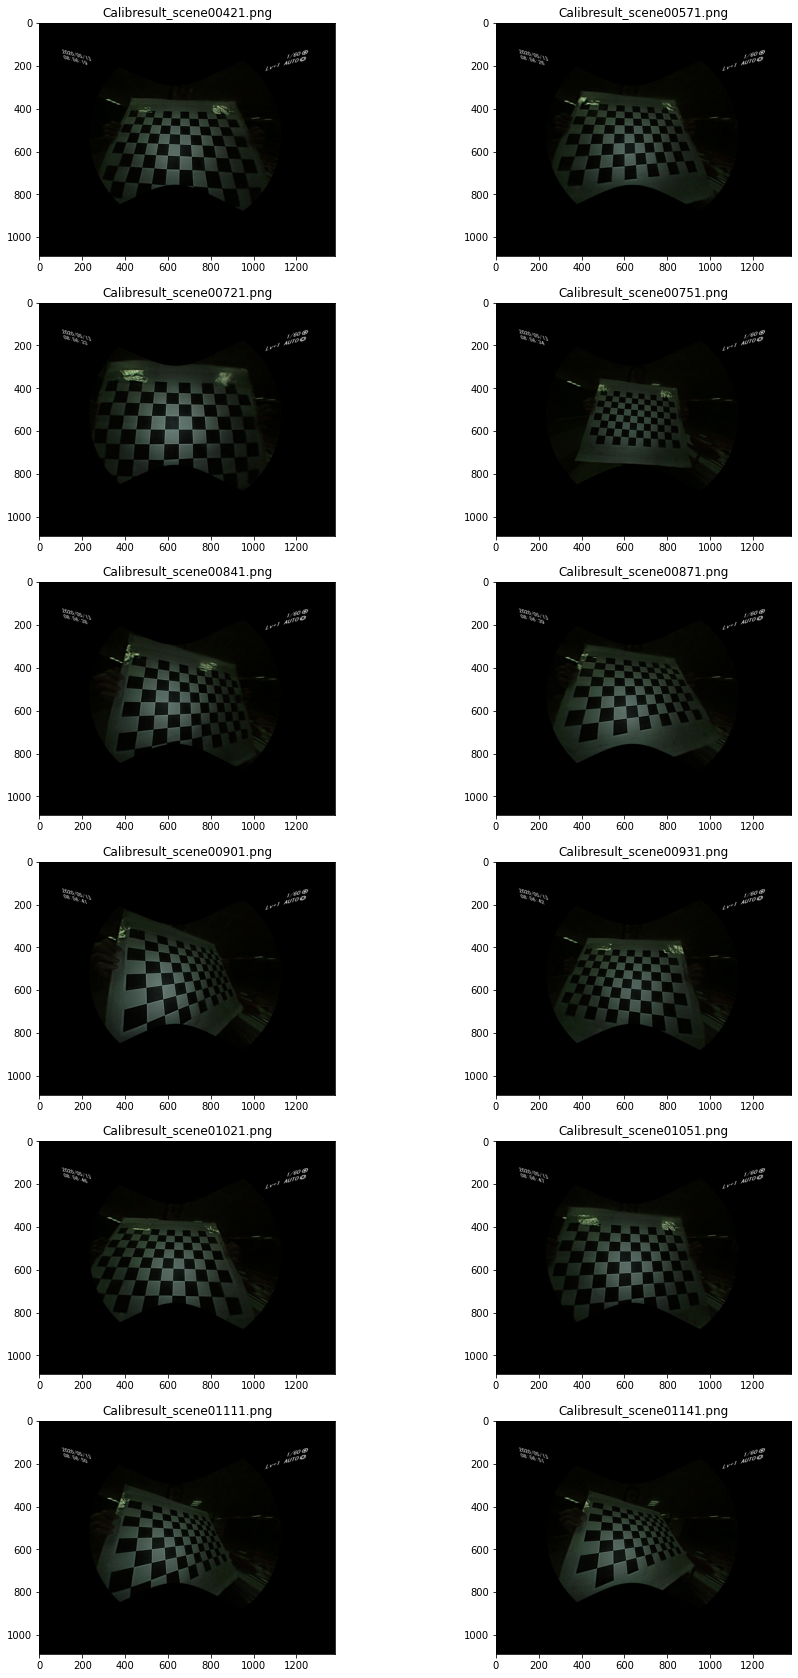

In [71]:
images=glob.glob('chessboard_unknow/result/*.png')
column=2
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))

# UNDISTORTION các ảnh bên ngoài
## Tập dữ liệu gồm 9 ảnh

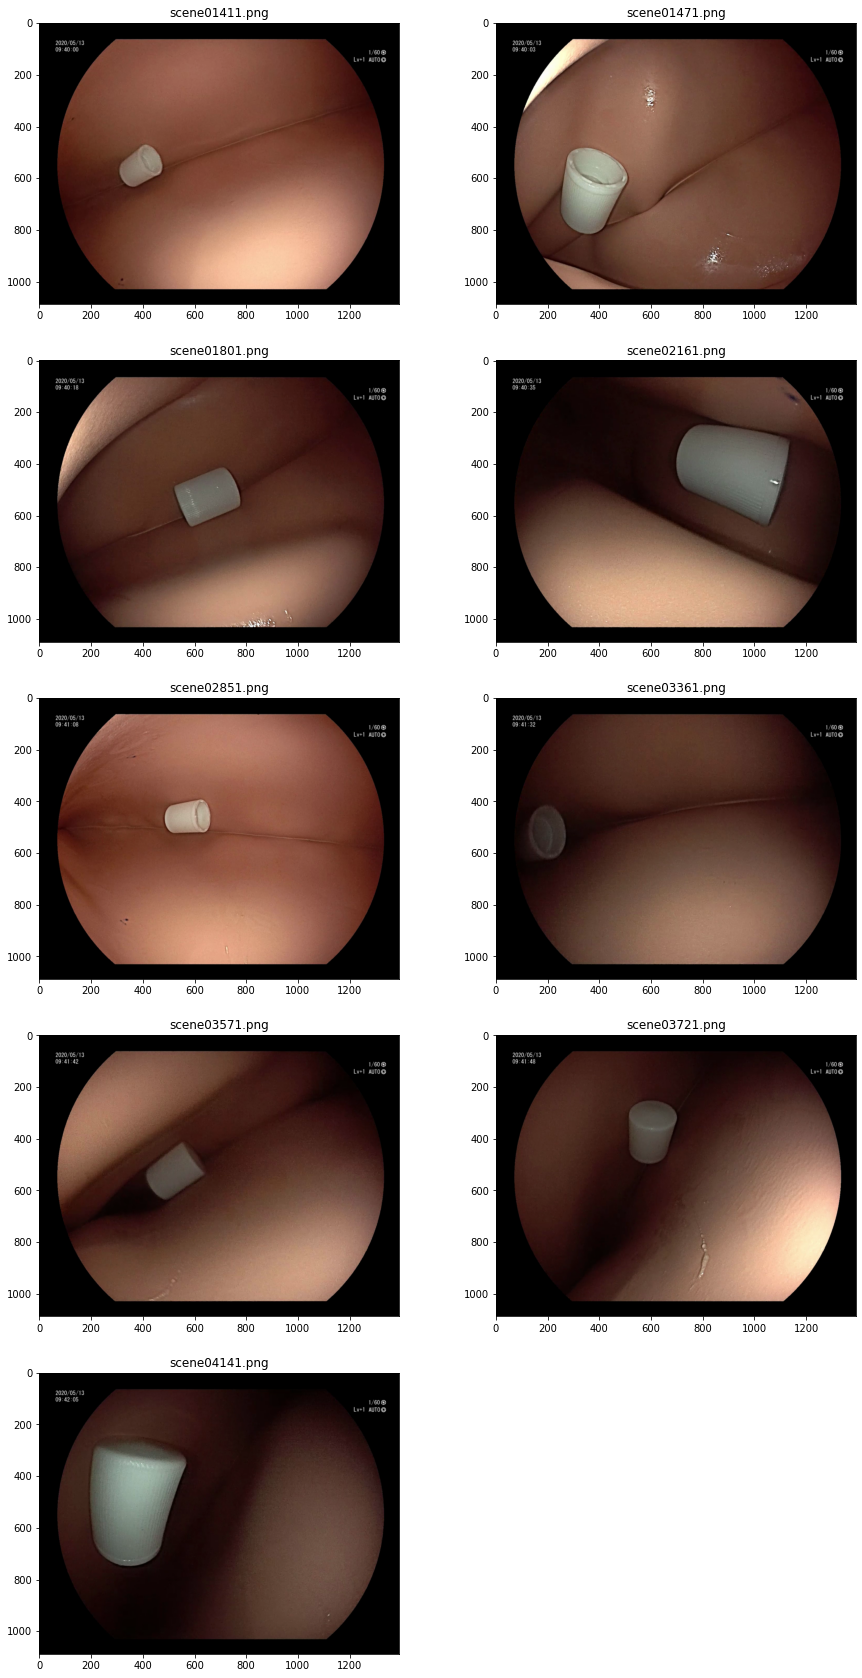

In [72]:
images=glob.glob('Scenes/*.png')
column=2
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))

## Thực hiện hiệu chỉnh

In [73]:
##### UNDISTORTION #####
img1 = cv2.imread("Scenes/scene01411.png")
h, w = img1.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(
    mtx, dist, (w, h), 1, (w, h))

resultImg = glob.glob("Scenes/*.png")
for rimg in resultImg:
    img = cv2.imread(rimg)
    
    # undistort
    mapx, mapy = cv2.initUndistortRectifyMap(
        mtx, dist, None, newcameramtx, (w, h), 5)
    dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # Ghi ản kết quả
    ############Your code here###############
    path = None
    pass
    ###########################################

# Lỗi phép chiếu (re-projection error)
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(
        objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print("total error", mean_error/len(objpoints))
cv2.waitKey(0)
cv2.destroyAllWindows()

total error 0.21195605444670207


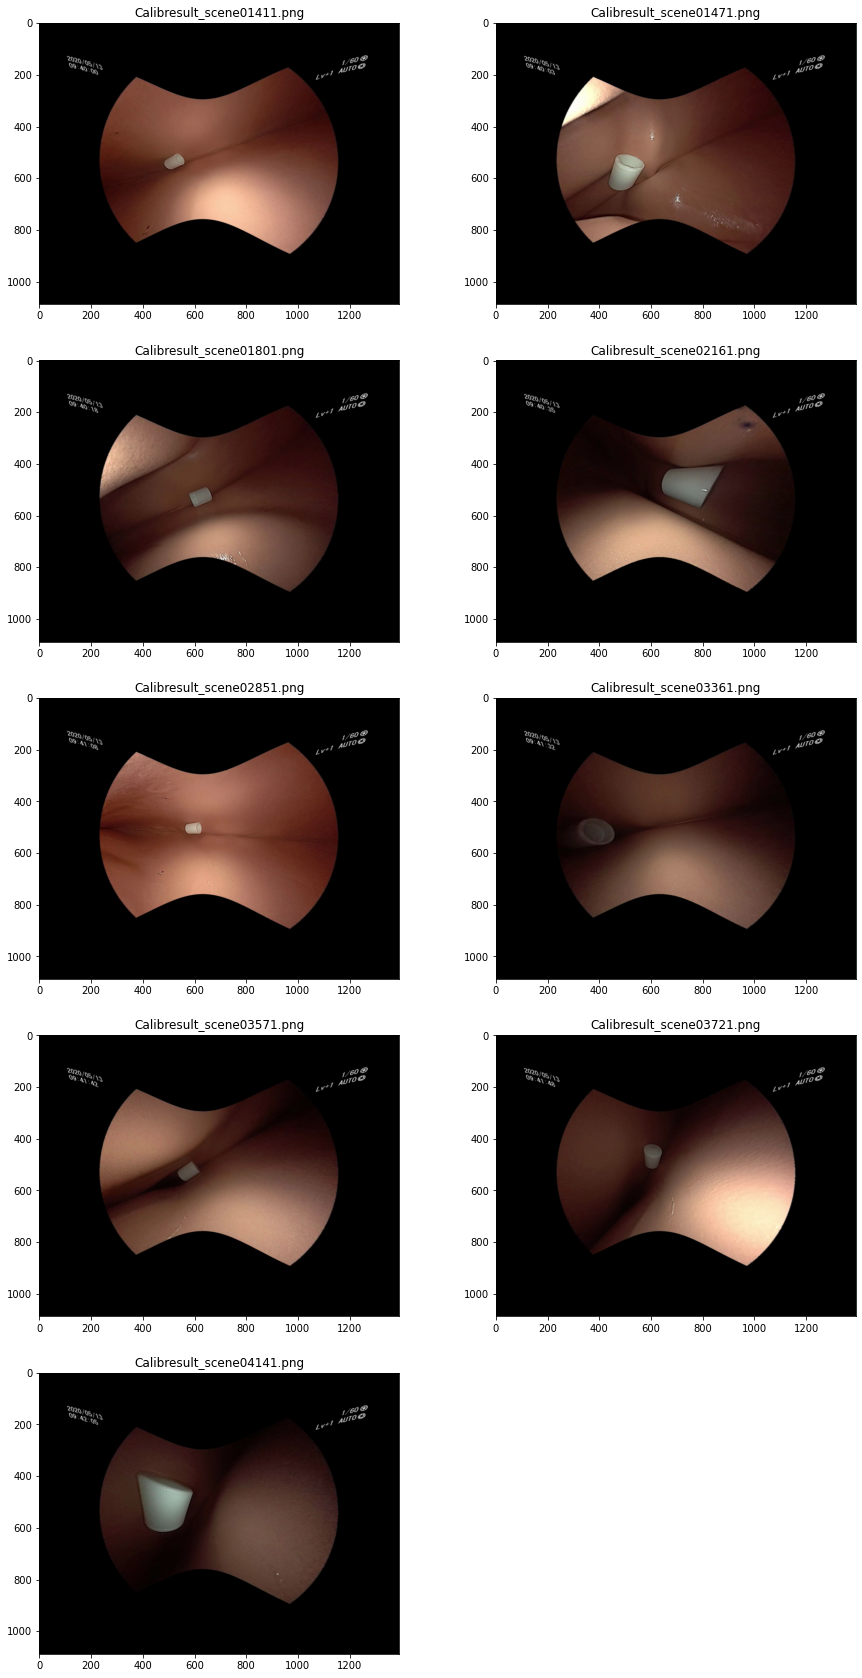

In [74]:
images=glob.glob('Scenes/result/*.png')
column=2
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))